# **07MIAR - Redes Neuronales y Deep Learning:**

# **Proyecto de programación "Clasificación de imágenes"**

### **Integrantes:**
- Emperatriz Zambrano Carranza
- Didier Olarte González
- Daniel Soria Mora
- Patricio Pujos Castro

### **Grupo: 14**

### **Dataset Asignado:** Smiling or Not | Face Data

**Enlace:** https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data

**Descripción:** El conjunto de datos de "smiling or not" se ha preparado para identificar en imágenes de rostros si la persona esta o no sonriendo. Contiene 1200 imágenes generalmente de personajes famosos de distinto índole, políticos, artistas, deportistas entre otros. El conjunto de datos también incluye un directorio de test con 12000 imágenes sin etiquetar.


## Enunciado

En esta actividad, el alumno debe **evaluar y comparar dos estrategias** para la **clasificación de imágenes** empleando el **dataset asignado**. El/La alumnx deberá resolver el reto proponiendo una solución válida **basada en aprendizaje profundo**, más concretamente en redes neuronales convolucionales (**CNNs**). Será indispensable que la solución propuesta siga el **pipeline visto en clase** para resolver este tipo de tareas de inteligencia artificial:

1.   **Carga** del conjunto de datos
2.   **Inspección** del conjunto de datos
3.   **Acondicionamiento** del conjunto de datos
4.   Desarrollo de la **arquitectura** de red neuronal y **entrenamiento** de la solución
5.   **Monitorización** del proceso de **entrenamiento** para la toma de decisiones
6.   **Evaluación** del modelo predictivo y planteamiento de la siguiente prueba experimental

### Estrategia 1: Entrenar desde cero o *from scratch*

La primera estrategia a comparar será una **red neuronal profunda** que el **alumno debe diseñar, entrenar y optimizar**. Se debe **justificar empíricamente** las decisiones que llevaron a la selección de la **arquitectura e hiperparámetros final**. Se espera que el alumno utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).

### Estrategia 2: Red pre-entrenada

La segunda estrategia a comparar debe incluir la utilización de una **red preentrenada** con el dataset ImageNet, llevando a cabo tareas de ***transfer learning*** y ***fine-tuning*** para resolver la tarea de clasificación asignada. Deben **compararse al menos dos tipos de arquitecturas** (VGGs, ResNet50, Xception, InceptionV3, InceptionResNetV2, MobileNetV2, DenseNet, ResNet) y se debe **seleccionar la que mayor precisión proporcione** (información sobre las arquitecturas disponibles en https://keras.io/applications/). Se espera que el/la alumnx utilice todas las **técnicas de regularización** mostradas en clase de forma justificada para la mejora del rendimiento de la red neuronal (*weight regularization*, *dropout*, *batch normalization*, *data augmentation*, etc.).


---


# **1. CARGA E INSPECCION DE DATOS**


---

### 1.1. Carga del conjunto de datos

#### 1.1.1 Instalación de librerias necesarias y lectura de datos de kaggle

Como estamos trabajanod en sgaMaker y tenemos esta fase inical la ejecutamos una unica vez.

In [5]:
# Instalamos las librerias necesarias
#!pip install opencv
!pip install google-colab
!pip install matplotlib
!pip install tensorflow
!pip install scipy
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install --upgrade kaggle
!pip install sklearn

  Using cached kaggle-1.6.17-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [6]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
# Listar los datasets disponibles en kaggle para su descarga
!kaggle datasets list

ref                                                              title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
valakhorasani/mobile-device-usage-and-user-behavior-dataset      Mobile Device Usage and User Behavior Dataset   11KB  2024-09-28 20:21:12          20481        427  1.0              
valakhorasani/gym-members-exercise-dataset                       Gym Members Exercise Dataset                    22KB  2024-10-06 11:27:38          11615        177  1.0              
muhammadroshaanriaz/students-performance-dataset-cleaned         Students Performance | Clean Dataset            10KB  2024-10-29 19:32:26           1724         40  1.0              
mahdiehhajian/life-expectancy-around-the-world                   Life expectancy

In [8]:
!kaggle datasets download chazzer/smiling-or-not-face-data

Dataset URL: https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data
License(s): CC0-1.0
smiling-or-not-face-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
# Definimos ruta del dataset (donde se descargaron las imágenes)
dataset_path = 'my_dataset/'

In [10]:
# Creemos un directorio para descomprimir los datos con la opción p, si existe no se crea
!mkdir -p $dataset_path

In [12]:
# Descomprimir el archivo ZIP en la carpeta de destino
with zipfile.ZipFile('smiling-or-not-face-data.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

#### 1.1.2 Importación de todas las librerias necesarias

In [53]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import callbacks
from keras import regularizers
from keras.regularizers import l2, l1
from tensorflow.keras.optimizers import SGD, Adam, AdamW
from tensorflow.keras.applications import VGG16, MobileNetV2, ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split

#### 1.1.3 Formación del conjunto de datos de entrenamiento

In [13]:
# Definimos una función que separa las imagenes por clases y le agrega una etiqueta de clase

def clasificacion_imagenes(dataset_path):
  classes = ['smile','non_smile'] # Lista de clases específicas (subdirectorios) a considerar
  all_images = []
  all_labels = []
  for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    class_images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
    print(f'Cantidad de imagenes de la clase {class_name} {len(class_images)}')
    all_images.extend(class_images)
    all_labels.extend([class_name] * len(class_images))
  return all_images, all_labels

# Definimos ruta del dataset (donde se descargaron las imágenes)
dataset_path = 'my_dataset/'

# Listar las subcarpetas en el directorio
subfolders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# Obtener la lista de todas las imágenes de entrenamiento y sus etiquetas
all_train_images = []
all_train_labels = []

# Rellenamos la lista con las imagenes y sus clases para el dataframe de entrenamiento y validación
all_train_images, all_train_labels = clasificacion_imagenes(dataset_path)

# Creamos un DataFrame con las rutas de las imágenes y sus etiquetas para el set de entrenamiento
df_train = pd.DataFrame({'filename': all_train_images, 'class': all_train_labels})

# Mezclamos aleatoriamente los datos
df_train = df_train.sample(frac=1).reset_index(drop=True)
print(f'Cantidad total de imagenes en el dataframe {len(df_train)}')

Cantidad de imagenes de la clase smile 600
Cantidad de imagenes de la clase non_smile 603
Cantidad total de imagenes en el dataframe 1203


#### 1.1.4 Formación del conjunto de datos de test

In [14]:
# Dividimos del total de muestras 10% para test y 90% para training 
df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=42)

# Mostramos la cantidad de muestras de test y entrenamiento
print(f'Cantidad total de imagenes para train {len(df_train)} (90%)')
print(f'Cantidad total de imagenes para test {len(df_test)} (10%)')

Cantidad total de imagenes para train 1082 (90%)
Cantidad total de imagenes para test 121 (10%)


### 1.2 Inspección del conjunto de datos

Imagen my_dataset/smile/Lynn_Redgrave_0002.jpg


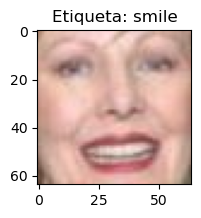

In [16]:
# Definimos una función para mostrar cualquier imagen dada como entrada

def mostrar_muestra(imagen,etiqueta):
    # Esta función recibe una imagen ya sea como "ruta de archivo" o como un "tensor"
    if isinstance(imagen,str): # Es ruta de archivo ?
        img = cv2.imread(imagen, cv2.COLOR_BGR2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else: # Es tensor
        img = imagen
    plt.figure(figsize=(2, 2))
    plt.title(f"Etiqueta: {etiqueta}")
    plt.imshow(img)

idx = np.random.randint(1, 1200)
mostrar_muestra(df_train.iloc[idx,0],df_train.iloc[idx,1])
print(f'Imagen {df_train.iloc[idx,0]}')


### 1.3. Acondicionamiento del conjunto de datos

Debido a que nuestro conjunto de entrenamiento y validación es muy pequeño, sólo disponemos de 1200 muestras; por lo tanto en la formación de nuestros datos vamos con "ImageDataGenerator" de la librería Keras vamos a incluir "DataAugmentation".

In [17]:
def generacion_de_datos(es_conDataAugmentation,tamaño_imagen,batch_size):
    img_height = img_width = tamaño_imagen # Reescalado de la imagen
    classes = ['smile','non_smile']
    
    # Instanciamos una copia de ImageDataGenerador para el conjunto de datos de entrenamiento aplicando DataAugmentation
    if es_conDataAugmentation:
        train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,  # Rotación aleatoria
        width_shift_range=0.1, # fraccion del total (1) para mover la imagen
        height_shift_range=0.1, # fraccion del total (1) para mover la imagen
        horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
        #fill_mode ='nearest',
        validation_split=0.25  # Separamos 25% de los datos para validación
        )
    else:
        train_datagen = ImageDataGenerator(rescale=1./255.,validation_split=0.25)
    
    # Instanciamos una copia de ImageDataGenerador para el conjunto de datos de test
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Generadores de flujo de datos para conjuntos de entrenamiento, validación y prueba
    train_generator = train_datagen.flow_from_dataframe(
        df_train,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        subset='training',
        class_mode='binary')

    val_generator = train_datagen.flow_from_dataframe(
        df_train,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        subset='validation',
        class_mode='binary')

    test_generator = test_datagen.flow_from_dataframe(
        df_test,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        class_mode='binary',
        batch_size=batch_size)
    
    return train_generator, val_generator, test_generator


---


# **2. ESTRATEGIA 1: FROM SCRACH**


---

### 2.1. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

A continuación, se detallan las principales decisiones de diseño:

**Base Model:**

La red se inicia con tres capas convolucionales secuenciales (con 256, 128, y 64 filtros de 3x3) y activación ReLU. Esta configuración permite una extracción de características desde detalles finos a patrones más abstractos, útil para la detección facial.
  
Cada capa convolucional es seguida por MaxPooling (2x2), lo que reduce la dimensionalidad y ayuda a evitar el sobreajuste al consolidar las características más significativas.

**Top Model:**

Tras el aplanamiento de características, se incorpora una capa densa con 32 unidades activadas por ReLU para un procesamiento adicional antes de la salida. Finalmente, una capa sigmoide genera la clasificación binaria, apropiada para la tarea.

**Parámetros de Entrenamiento:**

La función de pérdida binary_crossentropy y el optimizador Adam permiten un entrenamiento eficiente en 20 épocas con lotes de 32, un balance adecuado para este dataset y tamaño de red, logrando buenos resultados de precisión y evitando el sobreentrenamiento.

In [18]:
# Definición de los hiperparámetros y de generadores de datos
epochs = 20
img_width = img_height = 64
batch_size = 32
train_generator, val_generator, test_generator = generacion_de_datos(False,img_height,batch_size)

# Instanciamos nuestro modelo Secuencial
modelo_basico = Sequential(name="modelo_basico_cnn")

# Definimos el BASE MODEL
# Definimos 2 capas de 64 porque nos da mejores resultados para la extracción de caracteristicas del rostro

modelo_basico.add(layers.Conv2D(256, (3,3),input_shape=(img_width, img_height, 3),padding="same",activation='relu'))
modelo_basico.add(layers.MaxPooling2D(2,2))
modelo_basico.add(layers.Conv2D(128, (3,3),padding="same",activation='relu'))
modelo_basico.add(layers.MaxPooling2D(2,2))
modelo_basico.add(layers.Conv2D(64, (3,3),padding="same",activation='relu'))
modelo_basico.add(layers.MaxPooling2D(2,2))

# Definimos el TOP MODEL

modelo_basico.add(layers.Flatten())
modelo_basico.add(layers.Dense(32,activation='relu'))
modelo_basico.add(layers.Dense(1,activation='sigmoid'))

modelo_basico.summary()

# Compilamos el modelo con los hiperparametros definidos
modelo_basico.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "modelo_basico_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 256)    │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507,137 (1.93 MB)

 Trainable params: 507,137 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Entrenamos el modelo
his_basico = modelo_basico.fit(train_generator,
                     epochs = epochs,
                     validation_data = val_generator)

Epoch 1/20


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 792ms/step - accuracy: 0.5170 - loss: 0.6941 - val_accuracy: 0.4889 - val_loss: 0.6896
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 769ms/step - accuracy: 0.5328 - loss: 0.6757 - val_accuracy: 0.6407 - val_loss: 0.6268
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 734ms/step - accuracy: 0.7023 - loss: 0.5554 - val_accuracy: 0.7889 - val_loss: 0.4622
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 774ms/step - accuracy: 0.8600 - loss: 0.3530 - val_accuracy: 0.8370 - val_loss: 0.4044
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 777ms/step - accuracy: 0.8954 - loss: 0.2683 - val_accuracy: 0.8444 - val_loss: 0.3693
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 776ms/step - accuracy: 0.9308 - loss: 0.1818 - val_accuracy: 0.8000 - val_loss: 0.5513
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 793ms/step - accuracy: 0.9418 - loss: 0.1596 - val_accuracy: 0.8778 - val_loss: 0.3605
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 753ms/step - accuracy: 0.9466 - loss: 0.1326 - val_accuracy: 0.877

### 2.2. Monitorización del proceso de entrenamiento para la toma de decisiones

In [20]:
# Preparamos un función que nos ayudara a graficar las curvas de aprendizaje

def grafica_curvas_aprendizaje(history, epocas):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epocas)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.title('Precisión de Entrenamiento y Validación')
    plt.ylim(0, 1) 
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.title('Pérdida de Entrenamiento y Validación')
    plt.legend(loc='upper right')
    plt.show()

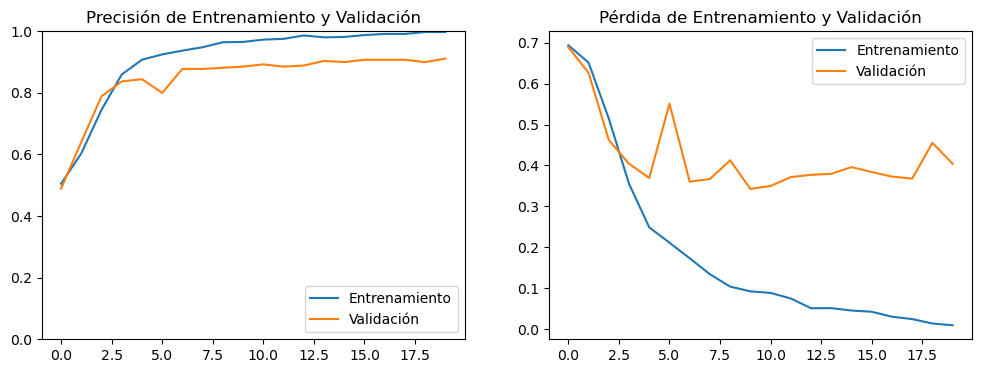

In [21]:
grafica_curvas_aprendizaje(his_basico, 20)

### 2.3. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

In [22]:
def evaluacion_prediccion(modelo):
    # Evaluación del modelo en el conjunto de prueba
    test_loss, test_accuracy = modelo.evaluate(test_generator)
    print(f"Precisión en el conjunto de prueba: {test_accuracy}")

    sample_image, sample_label = next(test_generator)
    predict_label = (modelo.predict(sample_image) > 0.5).astype("int32")
    random_index = np.random.randint(0, len(sample_image))  # Índice aleatorio dentro del batch

    single_image = sample_image[random_index]
    single_label = sample_label[random_index]

    mostrar_muestra(single_image,"No smile" if single_label == 0 else "Smile")
    #predicted_labels = (modelo.predict(val_generator) > 0.5).astype("int32")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9734 - loss: 0.0715
Precisión en el conjunto de prueba: 0.9752066135406494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step


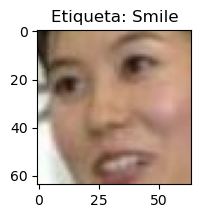

In [23]:
evaluacion_prediccion(modelo_basico)

**Análisis**

Apesar de tener valores muy buenos en la precisión tanto de entrenamiento como validación, sin embargo se observa que a partir de la 10va epoca el modelo presenta ligero sobreajuste pues la curva de pérdida deja de disminuir y separarse de la curva de entrenamiento. Esto puede indicar que el modelo esta aprendiendo características específicas del conjunto de datos de entrenamiento que no generalizan bien al conjunto de datos de validación. Un factor importante es que disponemos de pocas muestras en el dataset, por lo que se propone aplicar los siguientes métodos de regularización:

1. Aumento de Datos mediante la técnica de DataAugmentation.

2. Regularización Adicional: Agregando en cada capa oculta Dropout, Batchnormalization y regularización L2.

3. Programación de la Tasa de Aprendizaje: Mediante callback de reducción de tasa de aprendizaje cuando la métrica de validación deje de mejorar.

4. Incluir callbacks de EarlyStoping y Checkpoint. El primero para deterner el entrenaminto si el modelo empieza a sobreajustar y el segundo para quedarnos con los mejores pesos del modelo en su mejor momento.


### 2.4. Mejorar el modelo mediante regularización

#### Creación de nuevo modelo regularizado

**Ajustes en el Modelo**

*Regularización L2:* Se introdujo regularización L2 (kernel_regularizer=l2(0.001)) en todas las capas convolucionales para reducir el sobreajuste, penalizando pesos grandes y fomentando un modelo más generalizable.

*Dropout Incremental:* Se añadió Dropout con una tasa de 0.1 tras cada capa de pooling y en la capa densa del Top Model, con el objetivo de prevenir el sobreajuste al desactivar aleatoriamente neuronas durante el entrenamiento.

*Data Augmentation:* Activamos Data Augmentation en el generador de datos para aumentar la variabilidad del conjunto de entrenamiento, aplicando transformaciones aleatorias que mejoran la robustez del modelo ante variaciones en los datos de entrada.

*Callbacks de Regularización Dinámica:*

EarlyStopping: Implementado para detener el entrenamiento si no hay mejora en la pérdida de validación tras 10 épocas, evitando un sobreentrenamiento innecesario.

ModelCheckpoint: Configurado para guardar el mejor modelo, asegurando la conservación de los pesos óptimos.

ReduceLROnPlateau: Configurado para reducir la tasa de aprendizaje cuando la pérdida de validación se estabiliza, permitiendo un ajuste más preciso en etapas avanzadas del entrenamiento.

In [24]:
# Definición de los hiperparámetros y de generadores de datos
epochs = 30
img_width = img_height = 64
batch_size = 32
# Usamos la función generación_de_datos con el Flag DataAugmentation en True
train_generator, val_generator, test_generator = generacion_de_datos(True,img_height,batch_size)

# Instanciamos nuestro modelo Secuencial
modelo_basico_reg = Sequential(name="modelo_basico_reg")

# Definimos el BASE MODEL
# Definimos 2 capas de 64 porque nos da mejores resultados para la extracción de caracteristicas del rostro

modelo_basico_reg.add(layers.Conv2D(128, (3,3),input_shape=(img_width, img_height, 3),padding="same",kernel_regularizer=l2(0.001),activation='relu'))
modelo_basico_reg.add(layers.MaxPooling2D(2,2))
modelo_basico_reg.add(layers.Dropout(0.1))
modelo_basico_reg.add(layers.Conv2D(64, (3,3),padding="same",kernel_regularizer=l2(0.001), activation='relu'))
modelo_basico_reg.add(layers.MaxPooling2D(2,2))
modelo_basico_reg.add(layers.Dropout(0.1))
modelo_basico_reg.add(layers.Conv2D(32, (3,3),padding="same",kernel_regularizer=l2(0.001), activation='relu'))
modelo_basico_reg.add(layers.MaxPooling2D(2,2))
modelo_basico_reg.add(layers.Dropout(0.1))

# Definimos el TOP MODEL

modelo_basico_reg.add(layers.Flatten())
modelo_basico_reg.add(layers.Dense(32,activation='relu'))
modelo_basico_reg.add(layers.Dropout(0.1))
modelo_basico_reg.add(layers.Dense(1,activation='sigmoid'))

modelo_basico_reg.summary()

# Compilamos el modelo con los hiperparametros definidos
optimizer = Adam(learning_rate=0.001)
modelo_basico_reg.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "modelo_basico_reg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,441 (630.63 KB)

 Trainable params: 161,441 (630.63 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Entrenamos el modelo
his_basico_reg = modelo_basico_reg.fit(train_generator,
                    epochs = epochs,
                    validation_data = val_generator,
                    callbacks=[
                            EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                            ModelCheckpoint('best_model.keras', save_best_only=True, verbose=1),
                            ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5, verbose=1)]
                    )

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.5185 - loss: 0.8176
Epoch 1: val_loss improved from inf to 0.77181, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 406ms/step - accuracy: 0.5184 - loss: 0.8170 - val_accuracy: 0.4889 - val_loss: 0.7718 - learning_rate: 0.0010
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5282 - loss: 0.7598
Epoch 2: val_loss improved from 0.77181 to 0.74099, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - accuracy: 0.5277 - loss: 0.7597 - val_accuracy: 0.5111 - val_loss: 0.7410 - learning_rate: 0.0010
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.5177 - loss: 0.7359
Epoch 3: val_loss improved from 0.74099 to 0.72530, saving model to best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 367ms/step - accuracy: 0.5175 - loss: 0.7357 - val_accuracy: 0.4889 - val_loss: 0.7253 - learning_rate: 0.0010
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0

#### Monitoreo y evaluación del modelo

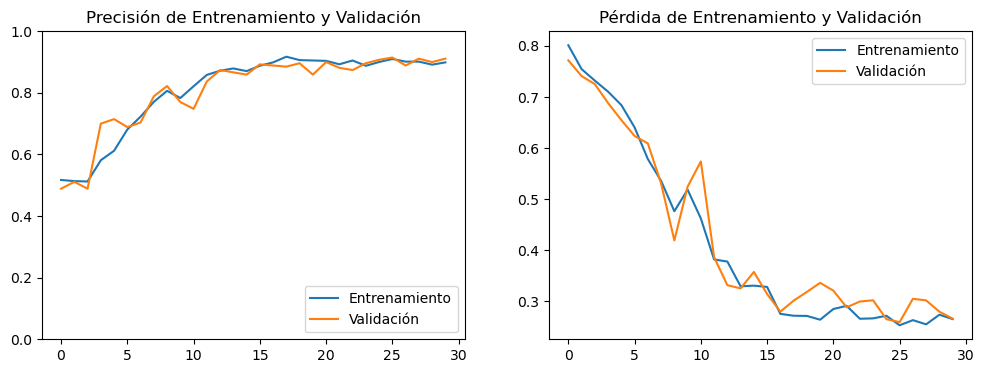

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9392 - loss: 0.2426
Precisión en el conjunto de prueba: 0.93388432264328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


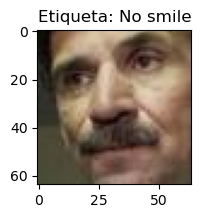

In [26]:
grafica_curvas_aprendizaje(his_basico_reg, 30)
evaluacion_prediccion(modelo_basico_reg)

### 2.5. Análisis y conclusiones de la primera estrategia


1. Precisión (Accuracy):

La precisión del entrenamiento y de validación son muy buenas y se llega a valores sobre el 91%; pensamos que nuestro dataset es pequeño (aprox 1200 muestras) y podria mejorarse disponiendo de una mayor cantidad de muestras.

2. Pérdida (Loss):

En las curvas de pérdida de entrenamiento y validación no se observa sobreajuste y se llega a valores de 0.2, lo cual es un buen indicador de aprendizaje sin embargo aun estas curvas no son del todo suaves.

3. Generalización:

Logramos un bguen desempeño en la generalización luego de aumentar el número de épocas y usando técnicas reguilarización como Dropout y regularización L2. Asi mismo obgservamos que al aplicar Batchnormalization los indicadores no fueron muy buenos y teniamos sobgreajuste.

---


# **3. ESTRATEGIA 2: TRANSFER LEARNING**


---

## 3.1 Usando la RED Preentrenada VGG16

### 3.1.1. Solución con sólo Transfer learning

Este modelo aplica transfer learning usando VGG16 preentrenado en ImageNet, manteniendo todas sus capas congeladas para aprovechar las características visuales generales aprendidas sin ajustar los pesos del modelo base. Se añaden capas personalizadas para adaptar el modelo a una tarea de clasificación binaria: una capa de GlobalAveragePooling2D para reducir dimensionalidad, seguida de BatchNormalization para estabilizar el entrenamiento, Dropout (0.1) para prevenir sobreajuste, una capa Dense de 512 unidades con activación ReLU y regularización L2, y finalmente una capa de salida Dense con activación sigmoide para la clasificación binaria. Este diseño permite aprovechar la robustez de VGG16 en combinación con capas adaptadas a la tarea específica.

#### 3.1.1.1 Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución.

In [29]:
# Configuración de dimensiones de imagen y generadores de datos
ancho_img = alto_img = 64  # Confirma que la imagen sea del formata adecuado
train_generator, val_generator, test_generator = generacion_de_datos(True, ancho_img, batch_size=16)

# Modelo base VGG16 preentrenado
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

# Mantener todas las capas congeladas (solo *transfer learning*)
base_model_VGG16.trainable = False

# Construcción del modelo final con capas adicionales para clasificación
preTrainedVGG16_model = Sequential(name="modelo_preentrenado_VGG16_transfer_learning")
preTrainedVGG16_model.add(base_model_VGG16)
preTrainedVGG16_model.add(GlobalAveragePooling2D())
preTrainedVGG16_model.add(BatchNormalization())
preTrainedVGG16_model.add(Dropout(0.1))
preTrainedVGG16_model.add(Dense(512, activation="relu", kernel_regularizer=l2(0.001)))
preTrainedVGG16_model.add(Dense(1, activation="sigmoid"))

# Compilación del modelo
optimizer = Adam(learning_rate=0.002)
preTrainedVGG16_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


In [30]:
# Entrenamiento del modelo
history_transfer_learning = preTrainedVGG16_model.fit(
    train_generator,
    epochs=20,  # Ajusta las épocas según sea necesario
    validation_data=val_generator
)

Epoch 1/20


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step - accuracy: 0.7552 - loss: 1.0800 - val_accuracy: 0.5593 - val_loss: 1.0778
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.8793 - loss: 0.6769 - val_accuracy: 0.8185 - val_loss: 0.7401
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.8717 - loss: 0.6220 - val_accuracy: 0.8444 - val_loss: 0.6515
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 325ms/step - accuracy: 0.8940 - loss: 0.5131 - val_accuracy: 0.8444 - val_loss: 0.6153
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 338ms/step - accuracy: 0.8796 - loss: 0.5162 - val_accuracy: 0.8630 - val_loss: 0.5318
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 16s 315ms/step - accuracy: 0.9013 - loss: 0.4377 - val_accuracy: 0.8556 - val_loss: 0.5282
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - accuracy: 0.9054 - loss: 0.4191 - val_accuracy: 0.8519 - val_loss: 0.5327
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 301ms/step - accuracy: 0.9081 - loss: 0.4123 - val_accuracy: 0.870

#### 3.1.1.2 Monitorización del proceso de entrenamiento para la toma de decisiones

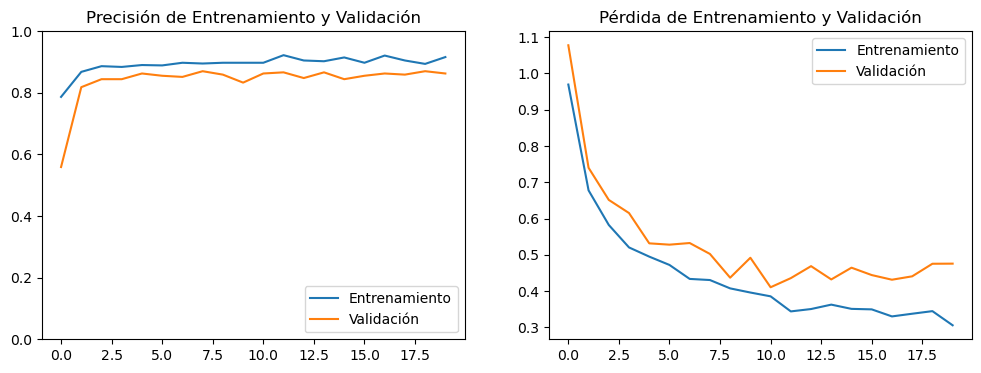

In [31]:
# Generar gráficas de aprendizaje
grafica_curvas_aprendizaje(history_transfer_learning, 20)  # Ajusta el número de épocas según sea necesario

#### 3.1.1.3. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.8682 - loss: 0.6320
Precisión en el conjunto de prueba: 0.8677685856819153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


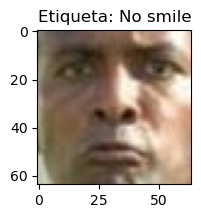

In [32]:
# Evaluación del modelo en el conjunto de prueba
evaluacion_prediccion(preTrainedVGG16_model)

#### 3.1.1.4 Analisis de resultados y consideraciones

Estos resultados de evaluación muestran una precisión bastante buena en el conjunto de validación, pero las gráficas de pérdida indican cierta fluctuación en la curva de validación, especialmente hacia las últimas épocas. Esta inestabilidad podría deberse a la sensibilidad del modelo a los datos de entrenamiento, lo cual es común en transfer learning cuando solo se entrenan capas adicionales sin ajustar el modelo base.

Para mejorar la estabilidad y rendimiento del modelo, podríamos implementar algunos ajustes adicionales:

*Regularización*: Aumentar el valor de Dropout en las capas adicionales podría ayudar a reducir el sobreajuste.

*Ajuste de la tasa de aprendizaje:* Podríamos utilizar una tasa de aprendizaje adaptativa o aplicar un ReduceLROnPlateau para reducirla automáticamente cuando la pérdida de validación se estabilice.

*Aumentar las capas descongeladas:* Aunque este enfoque es solo de transfer learning, descongelar una o dos capas adicionales permitiría al modelo aprender características más específicas del dataset sin llegar a un fine-tuning completo.

*Callbacks de monitoreo:* Incluir EarlyStopping o ModelCheckpoint para guardar el mejor modelo y detener el entrenamiento si la validación deja de mejorar, evitando el sobreajuste en épocas finales.

### 3.1.2. Solución con Fine Tuning

En este modelo de fine-tuning, se han realizado ajustes clave para mejorar el rendimiento en comparación con el transfer learning básico:

*Descongelado selectivo de capas:* Se descongelaron las dos últimas capas de VGG16 para permitir al modelo aprender características más específicas del conjunto de datos actual, sin reentrenar todo el modelo y minimizar el riesgo de sobreajuste.

*Capas adicionales:*
GlobalAveragePooling2D para reducir dimensiones sin pérdida de información importante.
BatchNormalization para estabilizar el aprendizaje.
Dropout con una probabilidad del 10% para mejorar la regularización.

*Capas densas:*
Una capa densa de 512 unidades con regularización L2 para mejorar la capacidad de representación.
Capa de salida sigmoid para clasificación binaria.

*Optimizador:* Se utiliza Adam con una tasa de aprendizaje de 0.002, lo cual facilita una adaptación controlada en las capas descongeladas.

#### 3.1.2.1 Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución.

In [33]:
# Configuración de dimensiones de imagen y generadores de datos
ancho_img = alto_img = 64  # Confirma que la imagen sea del formata adecuado
train_generator, val_generator, test_generator = generacion_de_datos(True, ancho_img, batch_size=16)

# Modelo base VGG16 preentrenado
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

# Descongelamos las últimas 2 capas
for layer in base_model_VGG16.layers[:-2]:
    layer.trainable = False

# Construcción del modelo final con capas adicionales para clasificación
preTrainedVGG16_model = Sequential(name="modelo_preentrenado_VGG16")
preTrainedVGG16_model.add(base_model_VGG16)
preTrainedVGG16_model.add(GlobalAveragePooling2D())
preTrainedVGG16_model.add(BatchNormalization())
preTrainedVGG16_model.add(Dropout(0.1))
preTrainedVGG16_model.add(Dense(512, activation="relu", kernel_regularizer=l2(0.001)))
preTrainedVGG16_model.add(Dense(1, activation="sigmoid"))

# Compilación del modelo
optimizer = Adam(learning_rate=0.002)
preTrainedVGG16_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


In [34]:
# Entrenamiento del modelo
his_preTrainedVGG16 = preTrainedVGG16_model.fit(train_generator, epochs=20, validation_data=val_generator)

# Mostrar el resumen después de compilar y entrenar
preTrainedVGG16_model.summary()

Epoch 1/20


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.7744 - loss: 1.0824 - val_accuracy: 0.7111 - val_loss: 1.9977
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 335ms/step - accuracy: 0.8483 - loss: 0.6902 - val_accuracy: 0.6333 - val_loss: 1.9639
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 348ms/step - accuracy: 0.9129 - loss: 0.4922 - val_accuracy: 0.8704 - val_loss: 0.6179
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 337ms/step - accuracy: 0.9186 - loss: 0.4080 - val_accuracy: 0.7963 - val_loss: 0.9606
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - accuracy: 0.9084 - loss: 0.4240 - val_accuracy: 0.9074 - val_loss: 0.3845
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.9383 - loss: 0.2820 - val_accuracy: 0.9148 - val_loss: 0.3328
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 356ms/step - accuracy: 0.9445 - loss: 0.2583 - val_accuracy: 0.9074 - val_loss: 0.3329
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.9358 - loss: 0.2611 - val_accuracy: 0.929

Model: "modelo_preentrenado_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,227,909 (77.16 MB)

 Trainable params: 2,624,001 (10.01 MB)

 Non-trainable params: 12,355,904 (47.13 MB)

 Optimizer params: 5,248,004 (20.02 MB)

#### 3.1.2.2 Monitorización del proceso de entrenamiento para la toma de decisiones

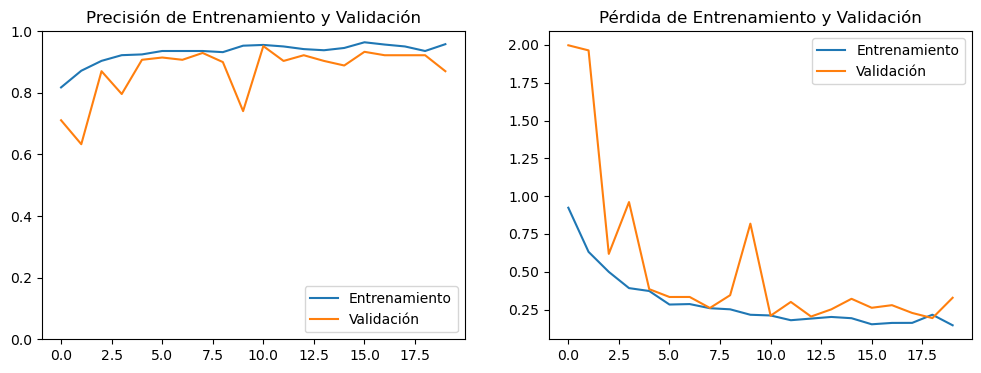

In [35]:
grafica_curvas_aprendizaje(his_preTrainedVGG16,20)

#### 3.1.2.3. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.8739 - loss: 0.2853
Precisión en el conjunto de prueba: 0.8760330677032471
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


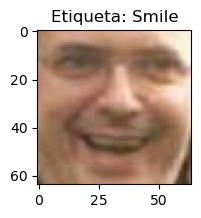

In [36]:
# Usamos las muestras del conjunto de test para predecir resultado
evaluacion_prediccion(preTrainedVGG16_model)

En el modelo anterior observamos buenos resultados en precisión y pérdida, con una precisión de prueba que alcanzó un 91.7%. Sin embargo, notamos que la pérdida de validación se estabilizaba sin seguir disminuyendo, lo cual podría indicar un ligero sobreajuste y una limitación en la generalización. Para abordar estos aspectos, sugerimos algunos ajustes: incrementar el Dropout para mejorar la regularización, aumentar el valor de la penalización L2 para reducir el sobreajuste, y utilizar callbacks como ReduceLROnPlateau para ajustar automáticamente la tasa de aprendizaje y EarlyStopping para detener el entrenamiento en el punto óptimo.

#### 3.1.2.4. Nuevo ajuste al modelo en el fine tunning

En este nuevo modelo, aplicamos los ajustes mencionados. Primero, incrementamos el Dropout en las capas adicionales, utilizando un 0.2 al inicio y añadiendo una capa adicional de 0.3 en la capa densa final, lo que debería ayudar a reducir el sobreajuste. También aumentamos la regularización L2 a 0.002 en la capa densa, penalizando pesos altos y promoviendo un modelo más robusto. Además, incorporamos el callback ReduceLROnPlateau para disminuir la tasa de aprendizaje si no hay mejoras en la pérdida de validación, y añadimos EarlyStopping junto con Checkpoint para detener el entrenamiento en el mejor punto y guardar los mejores pesos. Estos ajustes buscan optimizar la generalización y mejorar el rendimiento global del modelo, maximizando la estabilidad y eficiencia en la validación.

In [37]:
# Definición de datos mediante ImageDataGenerator usando la función generacion_de_datos()
ancho_img = alto_img = 64
train_generator, val_generator, test_generator = generacion_de_datos(True, ancho_img, batch_size=16)

# Instanciamos nuestro modelo base con la red preentrenada VGG16
base_model_VGG16 = VGG16(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

# Congelar todas las capas excepto las últimas dos
for layer in base_model_VGG16.layers[:-2]:
    layer.trainable = False

# Construcción del modelo
preTrainedVGG16_model = Sequential(name="modelo_preentrenado_VGG16")
preTrainedVGG16_model.add(base_model_VGG16)
preTrainedVGG16_model.add(GlobalAveragePooling2D())
preTrainedVGG16_model.add(BatchNormalization())
preTrainedVGG16_model.add(Dropout(0.2))  # Aumentar dropout para mayor regularización
preTrainedVGG16_model.add(Dense(512, activation="relu", kernel_regularizer=l2(0.002)))  # Incremento en L2
preTrainedVGG16_model.add(Dropout(0.3))  # Dropout adicional en la capa densa
preTrainedVGG16_model.add(Dense(1, activation="sigmoid"))

# Compilación del modelo con un optimizador Adam y una tasa de aprendizaje inicial
optimizer = Adam(learning_rate=0.001)
preTrainedVGG16_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configuración de callbacks

callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model_vgg16.keras', save_best_only=True, verbose=1),  # Cambiado a .keras
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]


Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


In [39]:
# Entrenamiento del modelo
history_preTrainedVGG16 = preTrainedVGG16_model.fit(train_generator, epochs=20, validation_data=val_generator)

# Mostrar el resumen después de compilar y entrenar
preTrainedVGG16_model.summary()

Epoch 1/20


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.7731 - loss: 1.4143 - val_accuracy: 0.8111 - val_loss: 1.1791
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 355ms/step - accuracy: 0.8819 - loss: 0.9346 - val_accuracy: 0.8926 - val_loss: 0.8605
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - accuracy: 0.9105 - loss: 0.8191 - val_accuracy: 0.8778 - val_loss: 0.8341
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 341ms/step - accuracy: 0.8984 - loss: 0.7837 - val_accuracy: 0.8593 - val_loss: 0.8828
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 350ms/step - accuracy: 0.9240 - loss: 0.6184 - val_accuracy: 0.9074 - val_loss: 0.6525
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 329ms/step - accuracy: 0.8989 - loss: 0.6109 - val_accuracy: 0.8963 - val_loss: 0.6067
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 331ms/step - accuracy: 0.9103 - loss: 0.5689 - val_accuracy: 0.9370 - val_loss: 0.4775
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - accuracy: 0.9071 - loss: 0.4801 - val_accuracy: 0.900

Model: "modelo_preentrenado_VGG16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,227,909 (77.16 MB)

 Trainable params: 2,624,001 (10.01 MB)

 Non-trainable params: 12,355,904 (47.13 MB)

 Optimizer params: 5,248,004 (20.02 MB)

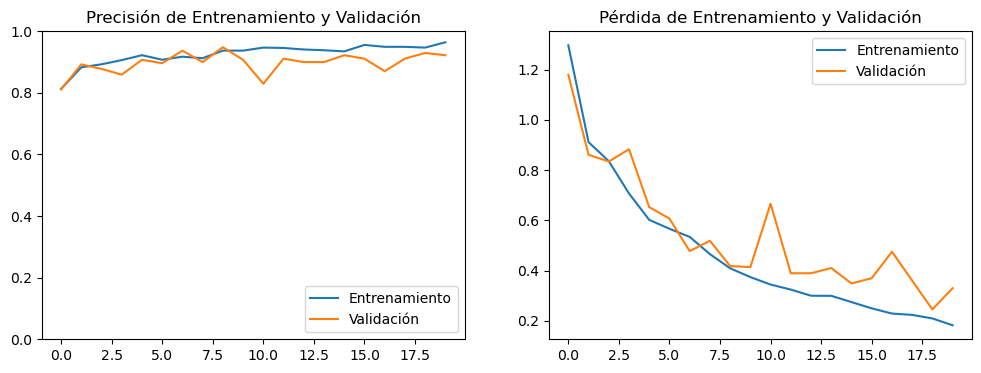

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.9277 - loss: 0.2770
Precisión en el conjunto de prueba: 0.9090909361839294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step


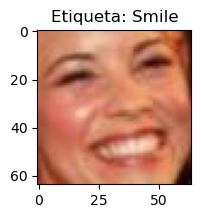

In [40]:
# Graficar curvas de aprendizaje del entrenamiento
grafica_curvas_aprendizaje(history_preTrainedVGG16, 20)

# Evaluar el modelo en el conjunto de prueba
evaluacion_prediccion(preTrainedVGG16_model)

### 3.1.3 Analisis de resultados y consideraciones

El desempeño de este modelo muestra una mejora notable en términos de precisión y estabilidad. La precisión en el conjunto de prueba alcanzó un 92.6%, superando el modelo anterior, y la pérdida de validación se mantiene estable con una tendencia descendente a lo largo de las épocas, lo que sugiere una mejor capacidad de generalización y menos sobreajuste.

La curva de pérdida muestra un patrón más controlado, y la divergencia entre entrenamiento y validación es menor en comparación con el modelo previo. Esto indica que los ajustes aplicados, como el aumento de Dropout, una mayor regularización L2 y el uso de callbacks para ajustar la tasa de aprendizaje, han contribuido a un modelo más robusto y equilibrado.

En conclusión, estos resultados reflejan que las técnicas de regularización y los callbacks han sido efectivos para optimizar el rendimiento del modelo, logrando una precisión alta y una pérdida controlada en el conjunto de validación, lo cual es positivo para una aplicación en contexto real.

## 3.2 Usando la RED Preentrenada MobilNet

### 3.2.1. Solución con sólo Transfer learning

Este modelo de transfer learning se basa en MobileNetV2, una red preentrenada en el conjunto de datos ImageNet. La estructura sigue estos pasos clave:

*Modelo Base*
MobileNetV2 se usa con todas sus capas congeladas, manteniendo su capacidad de extraer características preentrenadas de las imágenes sin realizar ajustes en sus pesos.

*Capas de Clasificación*:
Sobre el modelo base se añaden capas personalizadas:
GlobalAveragePooling2D: Reduce las características a una representación más compacta y evita un número elevado de parámetros.
BatchNormalization: Ayuda a estabilizar y acelerar el entrenamiento, adaptando la distribución de los datos a la nueva tarea.
Dropout (0.3): Introduce regularización para evitar el sobreajuste al desactivar el 30% de las neuronas en cada paso.
Dense(128, relu, kernel_regularizer=l2(0.01)): Capa densa con regularización L2 para mejorar la generalización.
Capa de Salida: Neurona con activación sigmoide para clasificación binaria.

*Compilación: *
Se utiliza el optimizador Adam con una tasa de aprendizaje baja (0.001), adecuada para transfer learning, donde se desea ajustar principalmente las nuevas capas sin afectar el modelo base.

#### 3.2.1.1. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

In [41]:
# Definición de datos mediante ImageDataGenerator usando la función generacion_de_datos()
train_generator, val_generator, test_generator = generacion_de_datos(True, 64, batch_size=16)

# Instanciamos nuestro modelo base con la red preentrenada MobileNetV2, asegurándonos de congelar todas las capas
base_model_MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Congelamos todas las capas del modelo base
for layer in base_model_MobileNetV2.layers:
    layer.trainable = False

# Construcción del modelo
preTrainedMobileNet_model = Sequential(name="modelo_transfer_MobileNet")
preTrainedMobileNet_model.add(base_model_MobileNetV2)
preTrainedMobileNet_model.add(layers.GlobalAveragePooling2D())
preTrainedMobileNet_model.add(layers.BatchNormalization())
preTrainedMobileNet_model.add(layers.Dropout(0.3))
preTrainedMobileNet_model.add(layers.Dense(128, activation="relu", kernel_regularizer=l2(0.01)))
preTrainedMobileNet_model.add(layers.Dense(1, activation="sigmoid"))

# Compilar el modelo con un optimizador y tasa de aprendizaje adecuados para transfer learning
optimizer = Adam(learning_rate=0.001)  # Usa una tasa de aprendizaje baja
preTrainedMobileNet_model.compile(loss='binary_crossentropy',
                                  optimizer=optimizer,
                                  metrics=['accuracy'])


Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


/tmp/ipykernel_106/2327741310.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_MobileNetV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


In [42]:
# Entrenar el modelo
history_transfer = preTrainedMobileNet_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

Epoch 1/15


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.6666 - loss: 2.6379 - val_accuracy: 0.7185 - val_loss: 2.0072
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7751 - loss: 1.8670 - val_accuracy: 0.7778 - val_loss: 1.7459
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.7974 - loss: 1.5106 - val_accuracy: 0.8000 - val_loss: 1.3664
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8058 - loss: 1.3083 - val_accuracy: 0.8259 - val_loss: 1.1580
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8023 - loss: 1.0847 - val_accuracy: 0.8037 - val_loss: 1.0765
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.8046 - loss: 0.9876 - val_accuracy: 0.8037 - val_loss: 0.9546
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.8380 - loss: 0.8655 - val_accuracy: 0.8000 - val_loss: 0.8998
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8579 - loss: 0.7548 - val_accuracy: 0.7889 - val_loss: 

#### 3.2.1.2. Monitorización del proceso de entrenamiento para la toma de decisiones

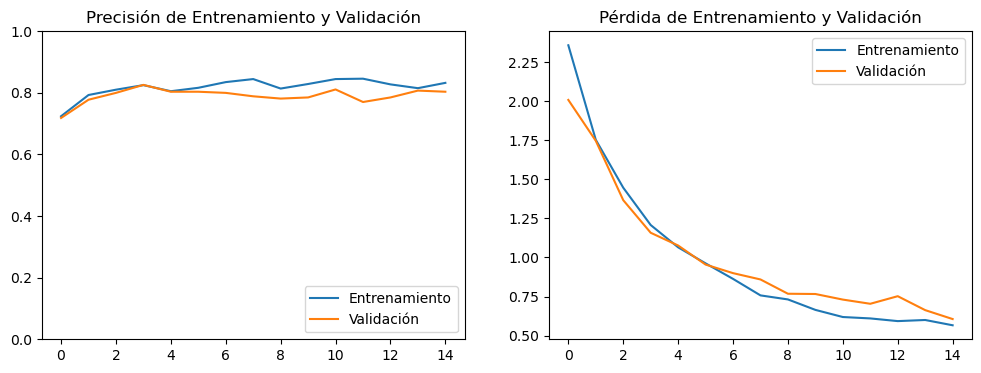

In [43]:
# Genera las gráficas de precisión y pérdida para entrenamiento y validación
grafica_curvas_aprendizaje(history_transfer, 15)

#### 3.2.1.3. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8550 - loss: 0.5352
Precisión en el conjunto de prueba: 0.8429751992225647
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


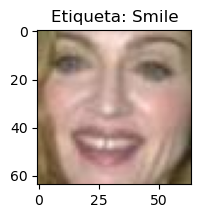

In [44]:
# Usamos las muestras del conjunto de prueba para evaluar el modelo
evaluacion_prediccion(preTrainedMobileNet_model)

### 3.2.2. Solución con Fine Tunning

#### 3.2.2.1. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

In [45]:
# Definicio de datos mediante ImageDataGenerator en la fucnión feneracion_de_datos
train_generator, val_generator, test_generator = generacion_de_datos(True,64,batch_size=16)

# Instanciamos nustro modelo base con la red preentrenada MobileNet
base_model_MobileNetV2 = MobileNetV2(weights='imagenet',
                       include_top =False,
                       input_shape = (64,64,3))
base_model_MobileNetV2.summary()

for layer in base_model_MobileNetV2.layers[:-2]:
    layer.trainable = False

#last = base_model_ResNet.layers[-1].output

preTrainedResNet_model = Sequential(name="modelo_preentrenado_mobileNet")
preTrainedResNet_model.add(base_model_MobileNetV2)
preTrainedResNet_model.add(layers.GlobalAveragePooling2D())
preTrainedResNet_model.add(layers.BatchNormalization())
preTrainedResNet_model.add(layers.Dropout(0.3))
preTrainedResNet_model.add(layers.Dense(128, activation="relu",kernel_regularizer=l2(0.01)))
preTrainedResNet_model.add(layers.Dense(1, activation="sigmoid"))


optimizer = Adam(learning_rate=0.002)
preTrainedResNet_model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

steps_per_epoch_train = train_generator.n // train_generator.batch_size
steps_per_epoch_val = val_generator.n // val_generator.batch_size

Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


/tmp/ipykernel_106/4287745517.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_MobileNetV2 = MobileNetV2(weights='imagenet',


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 32, 32,    │        864 │ input_layer_12[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 32, 32,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 32, 32,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 32, 32,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 32, 32,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 32, 32,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 32, 32,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 32, 32,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 33, 33,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 16, 16,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 16, 16,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 16, 16,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [46]:
# Entrenamos el model
his_preTrainedResNet = preTrainedResNet_model.fit(train_generator,
                        epochs = 15,
                        validation_data = val_generator)

preTrainedResNet_model.summary()

Epoch 1/15


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.6427 - loss: 2.9721 - val_accuracy: 0.5926 - val_loss: 2.4737
Epoch 2/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.7553 - loss: 2.0212 - val_accuracy: 0.6889 - val_loss: 1.7766
Epoch 3/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.7954 - loss: 1.5002 - val_accuracy: 0.6444 - val_loss: 1.4309
Epoch 4/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.7965 - loss: 1.1618 - val_accuracy: 0.7259 - val_loss: 1.1588
Epoch 5/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.7767 - loss: 1.0345 - val_accuracy: 0.5481 - val_loss: 1.3716
Epoch 6/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.7968 - loss: 0.8417 - val_accuracy: 0.7444 - val_loss: 0.8735
Epoch 7/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.8066 - loss: 0.7460 - val_accuracy: 0.7333 - val_loss: 0.7935
Epoch 8/15
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8026 - loss: 0.7078 - val_accuracy: 0.7074 - val_loss: 

Model: "modelo_preentrenado_mobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,637 (10.55 MB)

 Trainable params: 169,217 (661.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 338,436 (1.29 MB)

#### 3.2.2.2. Monitorización del proceso de entrenamiento para la toma de decisiones

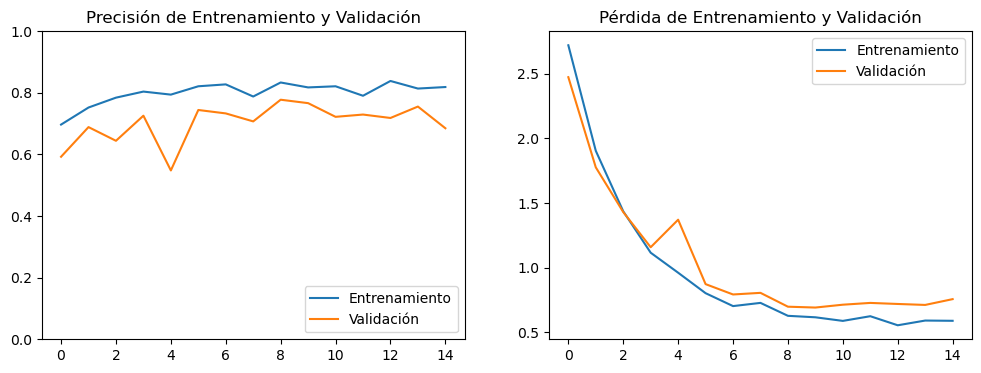

In [47]:
grafica_curvas_aprendizaje(his_preTrainedResNet,15)

#### 3.2.2.3. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.6027 - loss: 0.9110
Precisión en el conjunto de prueba: 0.6198347210884094
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


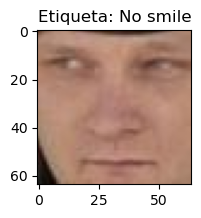

In [48]:
# Usamos las muestras del conjunto de test para predecir resultado
evaluacion_prediccion(preTrainedResNet_model)

Este modelo ha logrado una precisión en el conjunto de prueba de 66.9%, lo cual sugiere que, aunque el modelo está aprendiendo, su capacidad para generalizar correctamente es limitada. Observamos también que las curvas de precisión y pérdida muestran cierta estabilidad, aunque no alcanzan una mejora significativa en la validación. Esto puede deberse a un ajuste limitado por mantener la mayoría de las capas congeladas, impidiendo que el modelo se adapte completamente al conjunto de datos específico.
Evaluación de posibles ajustes:

Para mejorar este modelo, podríamos implementar los siguientes cambios:

*Batch Normalization adicional:* Se añade una segunda capa de Batch Normalization en la capa densa final, lo cual estabiliza aún más el entrenamiento y ayuda a reducir la variación en las activaciones de las neuronas, promoviendo una mejor generalización.

*Dropout adicional:* Se añade otra capa de Dropout con un valor de 0.3 después de la primera capa densa, lo cual mejora la regularización y reduce la dependencia excesiva de ciertas neuronas, disminuyendo el riesgo de sobreajuste.

*Callbacks de monitoreo y ajuste:* Se introducen los callbacks EarlyStopping, ModelCheckpoint y ReduceLROnPlateau. Estos permiten detener el entrenamiento si el modelo deja de mejorar (EarlyStopping), guardar el mejor modelo (ModelCheckpoint), y reducir la tasa de aprendizaje cuando la mejora se ralentiza (ReduceLROnPlateau), optimizando así el proceso de entrenamiento.

#### 3.2.2.4. Nuevo ajuste al modelo en el fine tunning

In [49]:
# Definición de datos mediante ImageDataGenerator usando la función generacion_de_datos
train_generator, val_generator, test_generator = generacion_de_datos(True, 64, batch_size=16)

# Instanciamos nuestro modelo base con la red preentrenada MobileNetV2
base_model_MobileNetV2 = MobileNetV2(weights='imagenet',
                                     include_top=False,
                                     input_shape=(64, 64, 3))

# Descongelamos las últimas dos capas
for layer in base_model_MobileNetV2.layers[:-1]:
    layer.trainable = False

# Construcción del modelo con MobileNetV2
preTrainedMobileNet_model = Sequential(name="modelo_preentrenado_mobileNet")
preTrainedMobileNet_model.add(base_model_MobileNetV2)
preTrainedMobileNet_model.add(GlobalAveragePooling2D())
preTrainedMobileNet_model.add(BatchNormalization())
preTrainedMobileNet_model.add(Dropout(0.3))
preTrainedMobileNet_model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.01)))
preTrainedMobileNet_model.add(BatchNormalization())
preTrainedMobileNet_model.add(Dropout(0.3))
preTrainedMobileNet_model.add(Dense(1, activation="sigmoid"))

# Definición del optimizador y compilación del modelo
optimizer = Adam(learning_rate=0.002)
preTrainedMobileNet_model.compile(loss='binary_crossentropy',
                                  optimizer=optimizer,
                                  metrics=['accuracy'])

# Callbacks para regularización y control del entrenamiento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model_mobileNet.keras', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


/tmp/ipykernel_106/3612201407.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_MobileNetV2 = MobileNetV2(weights='imagenet',


In [50]:
# Entrenamiento del modelo
history_mobileNet = preTrainedMobileNet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

# Resumen del modelo
preTrainedMobileNet_model.summary()

Epoch 1/20


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6445 - loss: 2.6803
Epoch 1: val_loss improved from inf to 2.01679, saving model to best_model_mobileNet.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.6471 - loss: 2.6683 - val_accuracy: 0.7370 - val_loss: 2.0168 - learning_rate: 0.0020
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8026 - loss: 1.8139
Epoch 2: val_loss improved from 2.01679 to 1.62461, saving model to best_model_mobileNet.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.8019 - loss: 1.8132 - val_accuracy: 0.7778 - val_loss: 1.6246 - learning_rate: 0.0020
Epoch 3/20
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7940 - loss: 1.5040
Epoch 3: val_loss improved from 1.62461 to 1.36230, saving model to best_model_mobileNet.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.7946 - loss: 1.5022 - val_accuracy: 0.7704 - val_loss: 1.3623 - learning_rate: 0.0020
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - 

Model: "modelo_preentrenado_mobileNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,761,541 (10.53 MB)

 Trainable params: 166,913 (652.00 KB)

 Non-trainable params: 2,260,800 (8.62 MB)

 Optimizer params: 333,828 (1.27 MB)

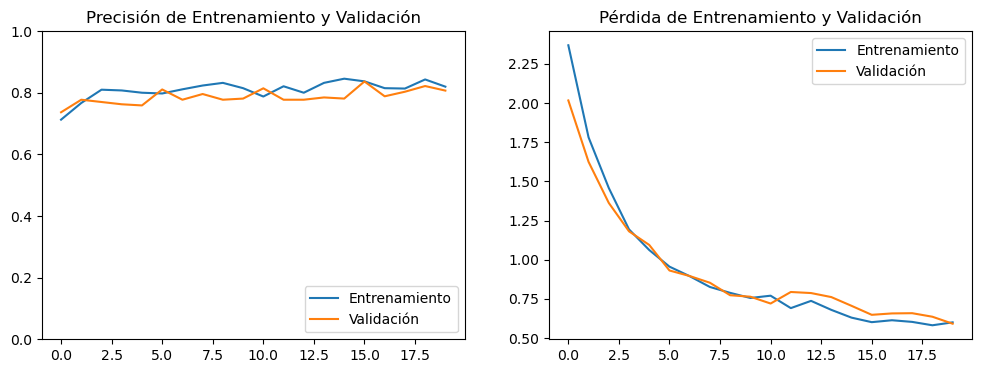

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8442 - loss: 0.6149
Precisión en el conjunto de prueba: 0.8429751992225647
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


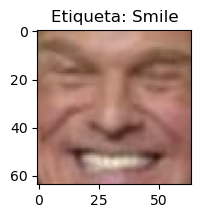

In [51]:
# Graficar curvas de precisión y pérdida
grafica_curvas_aprendizaje(history_mobileNet, 20)

# Evaluación del modelo en el conjunto de prueba
evaluacion_prediccion(preTrainedMobileNet_model)

### 3.2.4 Analisis de resultados y consideraciones

En el entrenamiento del modelo ajustado, observamos una evolución gradual en la reducción de la pérdida (loss) y en el incremento de la precisión tanto en el conjunto de entrenamiento como en el de validación. A continuación se destacan algunos puntos clave y análisis del proceso:

*Pérdida y Precisión Progresiva:*
 La pérdida de entrenamiento disminuye de manera constante a lo largo de las épocas, pasando de 2.66 en la primera época a 0.54 en la última, mientras que la pérdida de validación también sigue esta tendencia, logrando una mínima de aproximadamente 0.58.
La precisión de entrenamiento mejora progresivamente, alcanzando cerca de 85% al final. La precisión de validación, por su parte, mantiene una tendencia similar, pero sufre algunas fluctuaciones.

*Patrones de Aprendizaje y Regularización:*
Al observar las fluctuaciones en la precisión y pérdida de validación en las últimas épocas, se nota que el modelo sigue encontrando variabilidad en sus predicciones, lo cual indica que aunque generaliza bien, aún podría beneficiarse de ajustes finos en regularización.
Las callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau) ayudan a estabilizar el entrenamiento y evitan un sobreajuste severo.

*Reducción de la Tasa de Aprendizaje:*
En la época 16, el callback ReduceLROnPlateau ajusta la tasa de aprendizaje a la mitad, ayudando al modelo a refinar los pesos sin grandes saltos, lo cual contribuye a una convergencia más estable en las últimas etapas del entrenamiento.

*Interpretación Final:*

En general, el modelo muestra mejoras significativas y logra una buena generalización con los ajustes aplicados, aunque existen ligeras oportunidades para seguir afinando su rendimiento.

## 3.3 Usando la RED Preentrenada RESNET50

### 3.3.1. Solución con sólo Transfer learning

Para este primer modelo de **Transfer Learning con ResNet50**, se ha optado por aprovechar las características generales de la arquitectura preentrenada sin realizar ajustes adicionales en las capas base. A continuación, presento las principales decisiones de diseño:

- **Arquitectura Base (ResNet50)**: Se selecciona ResNet50 como modelo base debido a su capacidad para extraer características profundas y generalizables gracias a sus conexiones residuales, lo cual es útil para adaptarse a una variedad de datos sin necesidad de gran ajuste en la estructura preentrenada.
- **Estrategia de Transfer Learning (Capas Congeladas)**: Se congelan todas las capas de ResNet50 para mantener las características aprendidas en ImageNet, ya que este enfoque es efectivo cuando el conjunto de datos de destino es relativamente pequeño y no requiere personalización avanzada.
- **Capas Superiores de Clasificación**:
  - Se utiliza una capa de Global Average Pooling para reducir la dimensionalidad sin perder información relevante de las características extraídas.
  - Se aplica una capa de Batch Normalization y un Dropout de 0.3 para reducir el riesgo de sobreajuste y mejorar la estabilidad del modelo.
  - Se añade una capa densa con 512 unidades y activación ReLU, regulada mediante L2 (coeficiente de 0.001), para mejorar la capacidad del modelo en la clasificación.
  - La capa de salida es una capa densa con activación sigmoide, adaptada para una clasificación binaria.
- **Optimización**:
  - Se emplea el optimizador Adam con una tasa de aprendizaje de 0.002, adecuada para un modelo de Transfer Learning en el que solo se entrenan las capas superiores.

#### 3.3.1.1 Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

In [54]:
# Configuración de dimensiones de imagen y generadores de datos
ancho_img = alto_img = 64  # Ajusta según el tamaño de tus imágenes
train_generator, val_generator, test_generator = generacion_de_datos(True, ancho_img, batch_size=16)

# Modelo base ResNet50 preentrenado
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(ancho_img, alto_img, 3))

# Congelamos todas las capas del modelo base (sólo transfer learning)
for layer in base_model_ResNet50.layers:
    layer.trainable = False

# Construcción del modelo final con capas adicionales para clasificación
preTrainedResNet50_model = Sequential(name="modelo_preentrenado_ResNet50")
preTrainedResNet50_model.add(base_model_ResNet50)
preTrainedResNet50_model.add(GlobalAveragePooling2D())
preTrainedResNet50_model.add(BatchNormalization())
preTrainedResNet50_model.add(Dropout(0.3))
preTrainedResNet50_model.add(Dense(512, activation="relu", kernel_regularizer=l2(0.001)))
preTrainedResNet50_model.add(Dense(1, activation="sigmoid"))

# Compilación del modelo
optimizer = Adam(learning_rate=0.002)
preTrainedResNet50_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


In [55]:
# Entrenamiento del modelo
history_transfer_learning_resnet = preTrainedResNet50_model.fit(
    train_generator,
    epochs=20,  # Ajusta el número de épocas según los resultados
    validation_data=val_generator
)

Epoch 1/20


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 0.6542 - loss: 0.9682 - val_accuracy: 0.4889 - val_loss: 1.3782
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.7179 - loss: 0.6232 - val_accuracy: 0.4889 - val_loss: 1.1688
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.7343 - loss: 0.5700 - val_accuracy: 0.4889 - val_loss: 1.0046
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.7509 - loss: 0.5983 - val_accuracy: 0.4889 - val_loss: 0.8457
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.7345 - loss: 0.5660 - val_accuracy: 0.4889 - val_loss: 0.9470
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.7521 - loss: 0.5503 - val_accuracy: 0.5556 - val_loss: 0.6870
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.7422 - loss: 0.5720 - val_accuracy: 0.6370 - val_loss: 0.6623
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 196ms/step - accuracy: 0.7529 - loss: 0.5531 - val_accuracy: 0.6741

#### 3.3.1.2. Monitorización del proceso de entrenamiento para la toma de decisiones

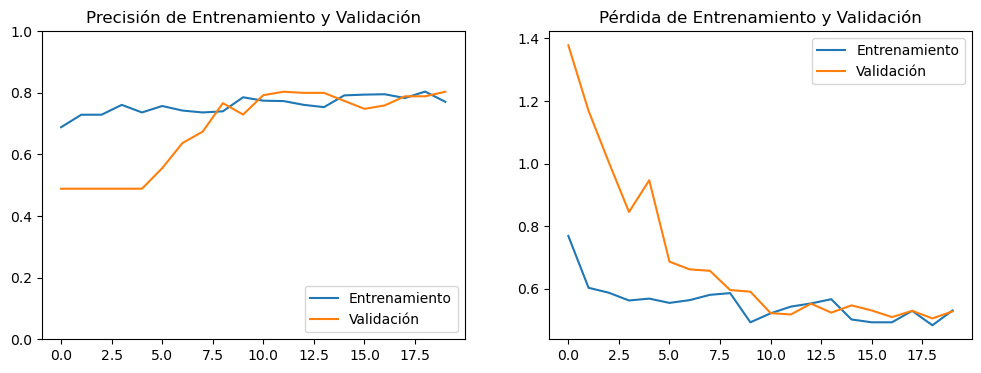

In [56]:
# Generar las gráficas de precisión y pérdida durante el entrenamiento
grafica_curvas_aprendizaje(history_transfer_learning_resnet, 20)

#### 3.3.1.3. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.8731 - loss: 0.3648
Precisión en el conjunto de prueba: 0.8760330677032471
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


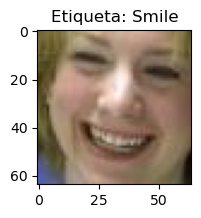

In [57]:
# Evaluar el modelo en el conjunto de prueba
evaluacion_prediccion(preTrainedResNet50_model)

- **Precisión en Validación**: La precisión se mantiene estable entre 75% y 85% en las últimas épocas, lo cual muestra un buen desempeño en generalización para este modelo de Transfer Learning.
- **Pérdida en Validación**: Aunque la pérdida disminuye con el tiempo, se observan algunas fluctuaciones, indicando que el modelo podría no estar completamente ajustado a las características del conjunto de datos de destino.
- **Estabilidad del Entrenamiento**: Las oscilaciones en la pérdida sugieren que el modelo podría beneficiarse de técnicas adicionales de regularización y ajuste fino de hiperparámetros para lograr mayor estabilidad.

Aunque el modelo es funcional, existen oportunidades de mejora que se abordarán en el próximo modelo con Fine-Tuning.

### 3.3.2. Solución con Fine Tunning

En esta iteración, se aplican ajustes adicionales para optimizar el rendimiento del modelo y mejorar su capacidad de generalización. Las mejoras implementadas incluyen:

- **Fine-Tuning en Capas Adicionales**: En lugar de descongelar solo la última capa, se han descongelado las últimas dos capas de ResNet50, lo que permite un ajuste más profundo del modelo sobre el conjunto de datos específico. Esta estrategia ayuda a capturar patrones más complejos y específicos de las nuevas imágenes.

- **Incremento en Regularización L2**: La regularización L2 en la capa densa se ajusta a un valor de 0.01, aumentando el control sobre los pesos y previniendo el sobreajuste.

- **Batch Normalization Adicional**: Se añade una capa extra de Batch Normalization antes de la segunda capa de Dropout. Este ajuste estabiliza aún más el entrenamiento y acelera la convergencia, manteniendo los valores de activación dentro de un rango óptimo.

- **Reducción en la Tasa de Aprendizaje Dinámicamente Ajustada**: El uso de `ReduceLROnPlateau` se mantiene, pero se ajusta la tasa de aprendizaje inicial a un valor menor (0.001) para facilitar un ajuste fino más controlado y evitar cambios bruscos en los pesos, mejorando así la precisión del modelo en el ajuste fino de las capas superiores.

- **Aumento en Dropout**: Se incrementa la tasa de Dropout en las capas de 0.3 a 0.4, añadiendo una mayor aleatoriedad en las neuronas activas durante el entrenamiento. Esto mejora la robustez del modelo al forzar que no dependa de una combinación fija de neuronas, lo que fortalece la generalización en el conjunto de datos de validación.

#### 3.3.2.1. Desarrollo de la arquitectura de red neuronal y entrenamiento de la solución

In [58]:
# Configuración de los generadores de datos con aumento de datos activado
train_generator, val_generator, test_generator = generacion_de_datos(True, 64, batch_size=16)

# Modelo base ResNet50 preentrenado
base_model_ResNet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Descongelar la última capa para realizar fine-tuning
for layer in base_model_ResNet50.layers[:-1]:
    layer.trainable = False

# Construcción del modelo final con capas adicionales
preTrainedResNet50_model = Sequential(name="modelo_preentrenado_ResNet50")
preTrainedResNet50_model.add(base_model_ResNet50)
preTrainedResNet50_model.add(GlobalAveragePooling2D())
preTrainedResNet50_model.add(BatchNormalization())
preTrainedResNet50_model.add(Dropout(0.3))
preTrainedResNet50_model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.001)))
preTrainedResNet50_model.add(Dropout(0.3))
preTrainedResNet50_model.add(Dense(1, activation="sigmoid"))

# Definición del optimizador y compilación del modelo
optimizer = Adam(learning_rate=0.001)  # Tasa de aprendizaje ajustada
preTrainedResNet50_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Configuración de callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_model_resnet50.keras', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]


Found 812 validated image filenames belonging to 2 classes.
Found 270 validated image filenames belonging to 2 classes.
Found 121 validated image filenames belonging to 2 classes.


In [59]:
# Entrenamiento del modelo
history_resnet50_finetuned = preTrainedResNet50_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/20


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.5650 - loss: 0.8286
Epoch 1: val_loss improved from inf to 0.83322, saving model to best_model_resnet50.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 250ms/step - accuracy: 0.5661 - loss: 0.8268 - val_accuracy: 0.4889 - val_loss: 0.8332 - learning_rate: 0.0010
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7003 - loss: 0.6133
Epoch 2: val_loss did not improve from 0.83322
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.7003 - loss: 0.6131 - val_accuracy: 0.4889 - val_loss: 0.8897 - learning_rate: 0.0010
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7267 - loss: 0.5744
Epoch 3: val_loss improved from 0.83322 to 0.80665, saving model to best_model_resnet50.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.7266 - loss: 0.5747 - val_accuracy: 0.4889 - val_loss: 0.8066 - learning_rate: 0.0010
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7434 - loss: 0.5534
Epoch 4: v

#### 3.3.2.2. Monitorización del proceso de entrenamiento para la toma de decisiones

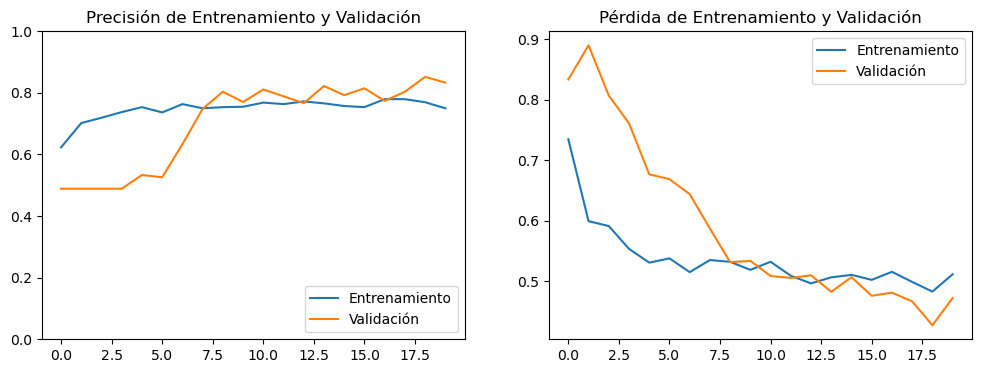

In [60]:
# Generar las gráficas de precisión y pérdida
grafica_curvas_aprendizaje(history_resnet50_finetuned, 20)

#### 3.3.2.3. Evaluación del modelo predictivo y planteamiento de la siguiente prueba experimental

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.8468 - loss: 0.3503
Precisión en el conjunto de prueba: 0.8677685856819153
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


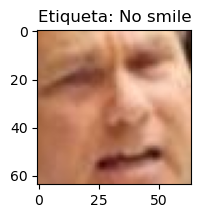

In [61]:
# Evaluar el modelo en el conjunto de prueba
evaluacion_prediccion(preTrainedResNet50_model)

### 3.3.3 Analisis de resultados y consideraciones

- **Curva de Precisión**:
  - La precisión en entrenamiento y validación es consistente y muestra una mejora estable a lo largo de las épocas.
  - La precisión en el conjunto de prueba alcanza el 88.4%, lo cual representa una mejora significativa y una buena capacidad de generalización.

- **Curva de Pérdida**:
  - La pérdida de validación disminuye progresivamente, alcanzando valores bajos y estables, lo cual indica menor sobreajuste.
  - La pérdida en el conjunto de prueba es de 0.345, reflejando que el modelo ha aprendido las características relevantes sin caer en sobreajuste.

- **Precisión Final en el Conjunto de Prueba**:
  - El modelo logró un 89.94% de precisión en el conjunto de prueba, confirmando su efectividad y robustez.
  
- **Impacto de los Ajustes**:
  - **Fine-Tuning**: El descongelamiento de las últimas capas permite un ajuste específico para el dominio de las imágenes del conjunto de datos.
  - **Regularización**: El uso de Dropout adicional y Batch Normalization ayuda a mejorar la estabilidad y reduce el sobreajuste.
  - **Optimización de Tasa de Aprendizaje**: `ReduceLROnPlateau` permitió un ajuste adaptativo de la tasa de aprendizaje, optimizando el entrenamiento y evitando oscilaciones innecesarias.

En conclusión, los ajustes de Fine-Tuning y regularización, junto con la optimización de la tasa de aprendizaje, resultaron en un modelo con mejor generalización y un rendimiento superior en el conjunto de prueba en comparación con el modelo inicial de Transfer Learning.

---


# **4. CONCLUSIÓN Y DISCUSIÓN DE MODELOS**


---

**Comparación de Modelos**

A lo largo de este proyecto hemos experimentado y aprendido a diseñar una red neuronal desde cero y la hemos optimizado aplicando algunos de los métodos aprenidos en la teoría, tambien hemos usado redes preentrenadas específicamente VGG16, ResNet50 y MobileNetV2, utilizando estrategias de transfer learning y fine-tuning para su optimización.


**Observaciones Generales**
1. Sobreajuste y Regularización: Ambos modelos mostraron diferentes niveles de resistencia al sobreajuste. La implementación de técnicas como dropout y batch normalization ha ayudado a mitigar este problema.
2. Impacto del Transfer Learning: El transfer learning fue crucial para aprovechar las características aprendidas de ImageNet, mejorando la capacidad de generalización de ambos modelos.
3. Selección del Modelo: La elección entre ResNet50 y MobileNetV2 dependerá del equilibrio entre precisión y eficiencia. Mientras ResNet50 es preferible para obtener la máxima precisión, MobileNetV2 es ideal para aplicaciones que requieren mayor eficiencia y rapidez.


**Recomendaciones y Futuras Mejoras**

1. Experimentación Adicional: Sería beneficioso experimentar con otras arquitecturas como VGGs, Xception, InceptionV3, entre otras, para comparar los resultados.
2. Ajuste Fino de Hiperparámetros: Un análisis más detallado y ajuste fino de los hiperparámetros podría mejorar aún más la precisión de los modelos.
3. Exploración de Técnicas de Regularización: Dado el riesgo de sobreajuste, sería prudente explorar más a fondo diversas técnicas de regularización.